In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, VGG16
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import keras_tuner as kt
import pandas as pd
from PIL import Image
import cv2 as cv
import pillow_heif
from deepface import DeepFace
import os
import tensorflow_datasets as tfds



In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
def batch_heic_to_png(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".heic"):
            input_path = os.path.join(input_folder, filename)
            output_filename = os.path.splitext(filename)[0] + ".jpg"
            output_path = os.path.join(output_folder, output_filename)
            
            try:
                # Open HEIC image and save as PNG
                heif_image = pillow_heif.open_heif(input_path)
                image = Image.frombytes(
                    heif_image.mode, 
                    heif_image.size, 
                    heif_image.data
                )
                image = image.resize((224,224))
                image = image.convert("L")
                image.save(output_path, format="JPEG", quality = 100)
                #print(f"Converted: {input_path} -> {output_path}")
            except Exception as e:
                print(f"Failed to convert {input_path}: {e}")

In [4]:
input_folder_happy = './Image Processing Dataset/Happy'
input_folder_sad = './Image Processing Dataset/Sad'

In [5]:
output_folder_happy = './Image Processing Dataset/Converted_Images/faces/Happy'
output_folder_sad = './Image Processing Dataset/Converted_Images/faces/Sad'

In [6]:
batch_heic_to_png(input_folder_happy, output_folder_happy)
batch_heic_to_png(input_folder_sad, output_folder_sad)

In [7]:
# Define the directory containing your images
input_dir_male = './Image Processing Dataset/gender/male'
output_dir_male = './Image Processing Dataset/Converted_Images/gender/male'
input_dir_female = './Image Processing Dataset/gender/female'
output_dir_female = './Image Processing Dataset/Converted_Images/gender/female'
# Create the output directory if it doesn't exist
def img_preprocessing(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Open an image file
            with Image.open(os.path.join(input_dir, filename)) as img:
                # Resize image to 224x224
                img = img.resize((224, 224))
                # Convert image to greyscale
                img = img.convert('L')
                # Save the processed image
                img.save(os.path.join(output_dir, filename))

print("All images have been processed and saved.")

All images have been processed and saved.


In [8]:
training_path = './Image Processing Dataset/Converted_Images/faces'

In [9]:
classes=[]
paths=[]
images=[]
for dirname, _, filenames in os.walk(training_path):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            class_name=(dirname.split('\\')[-1])
            file_path=os.path.join(dirname, filename)
            paths.append(file_path)
            classes.append(class_name)
#            try:
#                # Detect and align face
#                face = DeepFace.extract_faces(file_path, detector_backend="mtcnn",enforce_detection=False)
#                images.append(face)
#                
#            except Exception as e:
#                print(f"Error processing {file_path}: {e}")

In [10]:
print(len(classes))


15117


In [11]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

df=pd.DataFrame(columns=['path','class','label'])
df['path']=paths
df['class']=classes
df['label']=df['class'].map(normal_mapping)
print(len(df))

['Happy', 'Sad']
15117


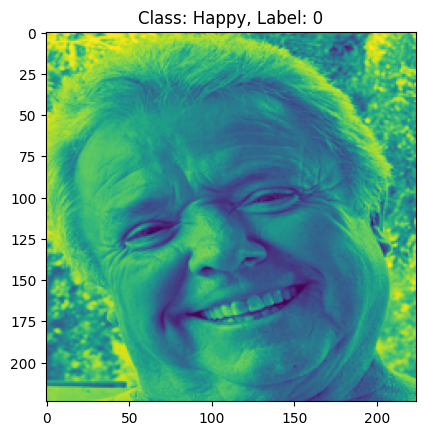

In [12]:
#register_heif_opener()
image_no = 22
image_path = df['path'].iloc[image_no]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Class: {df['class'].iloc[image_no]}, Label: {df['label'].iloc[image_no]}")
plt.axis('on')  # Hide axes
plt.show()

In [13]:
testing_path = './Image Processing Dataset/Converted_Images/faces'

In [14]:
print('number of samples: ', len(df['class']))
print('keys: ', list(df.keys()))
print('image shape: ', df.shape)
print('labels:', np.unique(df['class']))

number of samples:  15117
keys:  ['path', 'class', 'label']
image shape:  (15117, 3)
labels: ['Happy' 'Sad']


In [15]:
batch_size = 32
img_size = (224,224)
validation_split = 0.2

In [16]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 12094 files for training.


In [17]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 3023 files for validation.


In [18]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [19]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 48
Number of test batches: 47


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.prefetch(buffer_size=AUTOTUNE)

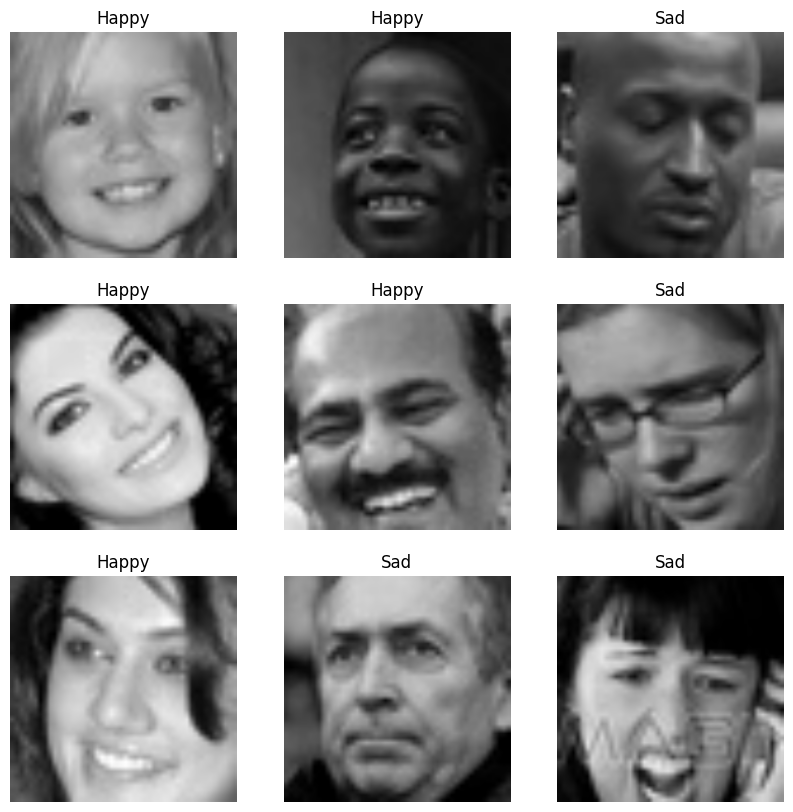

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(224,224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [23]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [24]:
image_batch, label_batch = next(iter(train_dataset))
# Resize the images to match the expected input shape of the base_model
#image_batch = tf.image.resize(image_batch, (img_size[0], img_size[1]))
image_batch = tf.image.resize(image_batch, (224, 224))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
def model_tuner(hp):
    my_model = models.Sequential([base_model,
                                layers.GlobalAveragePooling2D(),

                                Dense(hp.Int('Dense_1', min_value=128, max_value=512, step=128), activation='relu'),

                                Dropout(hp.Float('Dropout_1', min_value=0.2,max_value=0.5,step=0.1)),

                                #Dense(hp.Int('Dense_2', min_value=128, max_value=512, step=128), activation='relu'),

                                #Dropout(hp.Float('Dropout_2',min_value=0.2,max_value=0.5,step=0.1)),

                                layers.Dense(2, activation='sigmoid')])
    my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return my_model


In [27]:
tuner = kt.Hyperband(
    model_tuner,
    objective='val_accuracy',
    max_epochs=25,
    factor=3,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Convert labels to one-hot encoding
def preprocess_dataset(dataset):
    def one_hot_encode(image, label):
        label = tf.keras.utils.to_categorical(label, num_classes=2)
        return image, label
    return dataset.map(one_hot_encode)

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Trial 13 Complete [00h 43m 21s]
val_accuracy: 0.8630678057670593

Best val_accuracy So Far: 0.8630678057670593
Total elapsed time: 1d 20h 55m 29s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
128               |512               |Dense_1
0.2               |0.2               |Dropout_1
0.001             |0.0001            |learning_rate
9                 |9                 |tuner/epochs
3                 |3                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |1                 |tuner/round
0000              |0004              |tuner/trial_id

Epoch 4/9
  1/378 ━━━━━━━━━━━━━━━━━━━━ 39:29 6s/step - accuracy: 0.8438 - loss: 0.2395

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

In [27]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,900,482 (94.99 MB)

 Trainable params: 1,312,770 (5.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
train_ds=preprocess_dataset(train_ds)

In [ ]:
loss0, accuracy0 = best_model.evaluate(train_ds)

47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 976ms/step - accuracy: 0.6011 - loss: 0.7855


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.60


: 

In [ ]:
history = best_model.fit(train_ds,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_ds,
                    callbacks=[early_stopping])


Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.6801 - loss: 0.6222 - val_accuracy: 0.7768 - val_loss: 0.4479
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7887 - loss: 0.4461 - val_accuracy: 0.8025 - val_loss: 0.4178
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.8022 - loss: 0.4238 - val_accuracy: 0.8341 - val_loss: 0.3666
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.8102 - loss: 0.4050 - val_accuracy: 0.8361 - val_loss: 0.3533
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.8269 - loss: 0.3737 - val_accuracy: 0.8302 - val_loss: 0.3582
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.8388 - loss: 0.3659 - val_accuracy: 0.8446 - val_loss: 0.3566
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.8501 - loss: 0.3475 - val_accuracy: 0.8571 - val_loss: 0.3425
Epoch 8/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.8521 - loss: 0.3411 - val_accu

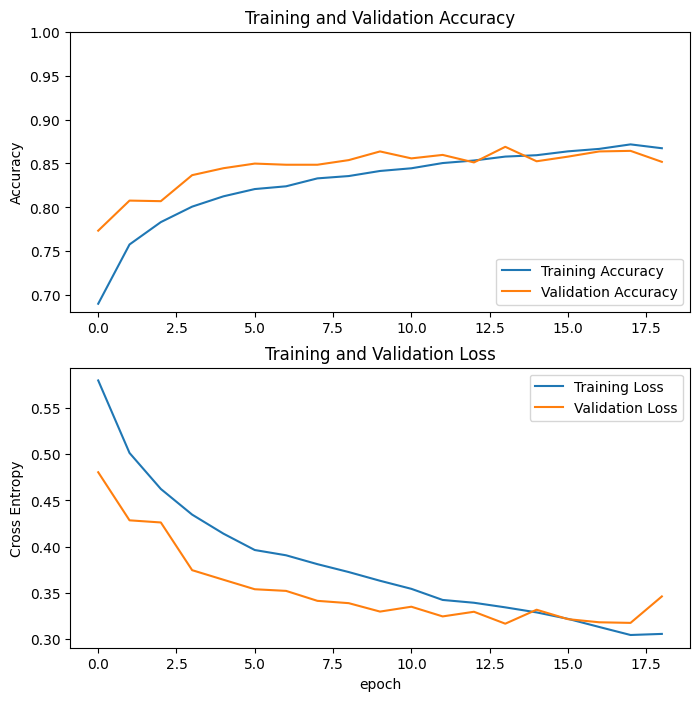

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = best_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 515ms/step - accuracy: 0.8565 - loss: 0.3351
Test accuracy : 0.8617021441459656


Predictions:
 [1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0
 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0]
Labels:
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0]


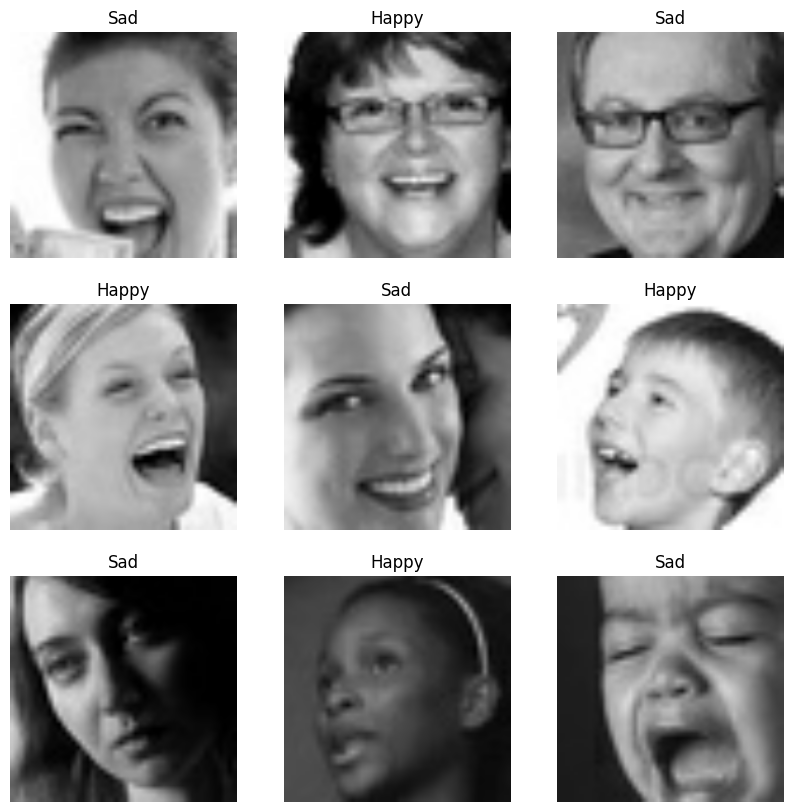

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 584ms/step
              precision    recall  f1-score   support

       Happy       0.60      0.60      0.60       889
         Sad       0.43      0.43      0.43       615

    accuracy                           0.53      1504
   macro avg       0.52      0.52      0.52      1504
weighted avg       0.53      0.53      0.53      1504



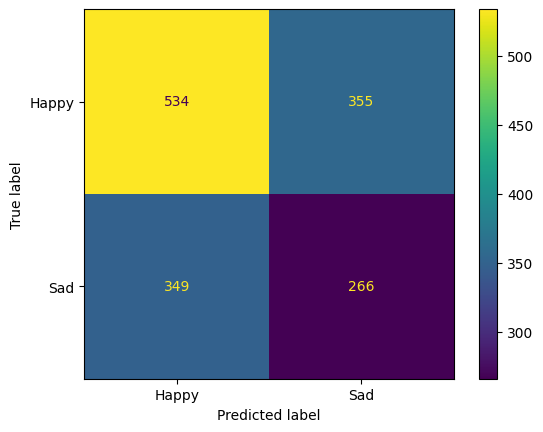

In [ ]:
val_labels = np.concatenate([y for x, y in test_ds], axis=0)
val_predictions = np.argmax(best_model.predict(test_ds), axis=-1)

# Calculate precision, recall, and F1-score
print(classification_report(val_labels, val_predictions, target_names=['Happy', 'Sad']))

# Display confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Happy', 'Sad'])
disp.plot()
plt.show()